## Name: Samridhi Makkar
## Andrew ID: smakkar
## Date: 13.10.2025
## Course: Practical computing for Biologists

## Import Statements

In [1]:
import numpy as np
from Bio import Align
import time
import random
import matplotlib.pyplot as plt

## Defining scoring parameters

In [2]:
#defining scoring parameters

#opens a new gap so heavy penalty
gap_open = -3

#extends an existing gap
gap_extend = -1

match = 3
mismatch = -2

## Defining all functions

In [3]:
def Max(var1, var2, var3) :
    '''Max function takes in the 3 scores and returns back the maximum score'''
    #if var1 is greater return that
    if var1 >= var2 and var1 >= var3:
        return var1
    #if var2 is greater return that
    elif var2 >= var1 and var2 >= var3: 
        return var2
    #if var3 is greater return that
    elif var3 >= var1 and var3 >= var2: 
        return var3
    else:
        return -1

In [4]:
def Max2(var1, var2):
    '''Max2 function takes in 2 scores and returns back the maximum score'''
    #if var1 is greater return that, if var2 is greater return that
    if var1 >= var2:
        return var1
    else:
        return var2

In [5]:
def score(s1, s2):
    '''score function takes as input the 2 bases, checks if the bases match or not, and returns match or mismatch score'''
    #return match score if bases match and mismatch score if bases dont match
    if s1 == s2:
        return match
    else:
        return mismatch

In [6]:
def scoring_system(scoring_matrix, I_matrix, D_matrix, seq1, seq2, i, j) :
    '''scoring_system takes as input the scoring, insertion and deletion matrices, 
    the sequences and input value i and j, and initiated the scoring rules to fill the matrix''' 

    #the strings being iterated and accessed (of each base)
    s1 = seq1[i-1]
    s2 = seq2[j-1]
    
    # if its a match then the match score gets updated to the charscore, if its a mismatch then the mismatch score gets updated 
    charScore = score(s1,s2)

    #the score comes from the diagonal for match
    Bases_match = scoring_matrix[i-1, j-1] + charScore

    #if there's a gap then the open gap penalty is introduced, and if the existing gaps is being extended, extend gap is being used
    Filling_I = scoring_matrix[i, j-1] + gap_open
    Extending_I = I_matrix[i, j-1] + gap_extend

    #the insertion matrix is updated
    I_matrix[i][j] = Max2(Filling_I, Extending_I)

    #if there's a gap then the open gap penalty is introduced, and if the existing gaps is being extended, extend gap is being used
    Filling_D = scoring_matrix[i-1, j] + gap_open
    Extending_D = D_matrix[i-1, j] + gap_extend
    
    #the deletion matrix is updated
    D_matrix[i][j] = Max2(Filling_D, Extending_D)

    #the max value is updated using the max function 
    Max_value = Max(Bases_match, I_matrix[i][j], D_matrix[i][j])
    
    #if the value of the scoring matrix is negative, its updated to 0
    if Max_value < 0:
        Max_value = 0 
    scoring_matrix[i][j] = Max_value

In [7]:
def mySmith(seq1, seq2):
    '''mySmith function is my implementation of the matrix initialisation,
    filling and traceback of Smith Waterman'''
    
    # 1. Matrix initialisation - the length of rows and columns with 1 + the length of the seqs
    rows = len(seq1) + 1 
    columns = len(seq2) + 1

    #initialising the 3 matrices to zeroes
    scoring_matrix = np.zeros((rows, columns), dtype = int)
    I_matrix = np.zeros((rows, columns), dtype=int)
    D_matrix = np.zeros((rows, columns), dtype=int)

    #initialising an alignment score variable to keep track of the highest score for traceback
    alignment_score = 0
    index_i = 0
    index_j = 0

    # 2. Matrix Filling - ranging over the matrix to fill the matrix by calling the scoring_system function
    for i in range(1,rows):
        for j in range(1,columns): #1-based indexing that is starting from 1,1 
            scoring_system(scoring_matrix, I_matrix, D_matrix, seq1, seq2, i, j)
            #tracking the highest score
            if scoring_matrix[i][j] >= alignment_score:
                alignment_score = scoring_matrix[i][j]
                index_i = i
                index_j = j

    #declaring empty lists to append the aligned sequences to 
    aligned_seq1 = []
    aligned_seq2 = []

    #determining which matrix the max score came from to set the initial state
    if alignment_score == scoring_matrix[index_i, index_j] and alignment_score > I_matrix[index_i, index_j] and alignment_score > D_matrix[index_i, index_j]:
         current_matrix = 'M' #assuming match/mismatch if score is not in I or D
    elif alignment_score == I_matrix[index_i, index_j]:
        current_matrix = 'I'
    else:
        current_matrix = 'D'

    # 3. Traceback
    #looping till the current score is positive and the matrix is inbounds
    while index_i > 0 and index_j > 0 and scoring_matrix[index_i][index_j] > 0:
        s1 = seq1[index_i-1]
        s2 = seq2[index_j-1]

        #if we are in the scoring matrix
        if current_matrix == 'M':
            #append the bases to the aligned sequence list if it was a match/mismatch 
            aligned_seq1.append(s1)
            aligned_seq2.append(s2)
            
            #checking the source of the new cell to set the next state
            prev_i, prev_j = index_i - 1, index_j - 1
            if scoring_matrix[prev_i, prev_j] == I_matrix[prev_i, prev_j]:
                current_matrix = 'I'
            elif scoring_matrix[prev_i, prev_j] == D_matrix[prev_i, prev_j]:
                current_matrix = 'D'
            else:
                current_matrix = 'M'
            index_i, index_j = prev_i, prev_j
                
        #if the current matrix is Insertion        
        elif current_matrix == 'I':
            #in Insertion matrix, gap is in seq1
            aligned_seq1.append('-')
            aligned_seq2.append(s2)
            
            #checking if this was an open or an extend to set the next state
            if I_matrix[index_i, index_j] == scoring_matrix[index_i, index_j-1] + gap_open:
                current_matrix = 'M'
            else: #it must have been an extend sostate continued
                current_matrix = 'I'
            # decreasing j index by 1
            index_j -= 1

        #if the current matrix is Deletion
        elif current_matrix == 'D':
            #in Deletion matrix, gap is in seq2
            aligned_seq1.append(s1)
            aligned_seq2.append('-')
            
            #checking if this was an open or an extend to set the next state
            if D_matrix[index_i][index_j] == scoring_matrix[index_i-1][index_j] + gap_open:
                current_matrix = 'M'
            else:
                current_matrix = 'D'
            #delete the index of i by 1
            index_i -= 1
            
    #once the traceback is done, reversing the sequence for readiblity and correct formatting
    aligned_seq1.reverse()
    aligned_seq2.reverse()

    #returning the aligned sequences as strings
    return  alignment_score, "".join(aligned_seq1), "".join(aligned_seq2)

In [8]:
def biopythonSmith(seq1, seq2):
    ''' biopythonSmith funtion uses the biopython library to align 
    2 sequences locally with the same scoring rules as mine'''

    #create an instance of the biopython pairwise aligner
    aligner = Align.PairwiseAligner()

    #assign local alignment mode
    aligner.mode = 'local' 

    #defining scoring parameters(again) but for the biopython library 
    aligner.match_score = 3
    aligner.mismatch_score = -2
    aligner.open_gap_score = -3
    aligner.extend_gap_score = -1

    #return the alignment on the 2 input sequences and return the alignment score     
    alignments = aligner.align(seq1, seq2)
    return alignments.score

In [9]:
def Random_Sequence_Generator(length):
    '''Random_Sequence_Generator function uses the random package to generate sequences with 
    bases A, G, C or T of different lengths'''

    #defining the bases - adenine, guanine, cytosine, thymine
    bases = ['A', 'C', 'G', 'T']

    #make random sequences based on lengths
    return ''.join(random.choice(bases) for _ in range(length))

## RESULTS AND VALIDATION

## Time Complexity between the 2 methods to compare my implementation using sequences of different lengths(base pairs) generated randomly

In [10]:
#declaring variables to define different lengths(bp) for the sequences, and empty lists to append the corresponding times to
sequenceLengths = [10, 20, 50, 100, 150, 200, 300, 400, 500]
myTimes = []
biopythonTimes = []

#formatting print statements
print("Running runtime comparison...in seconds\n")
print("Length \tMy Code \tBioPython ")

#looping through the length of sequences in the list to produce sequences of diff lengths by calling the random generator function
for length in sequenceLengths:
    seq1 = Random_Sequence_Generator(length)
    seq2 = Random_Sequence_Generator(length)
    
    #timing my implementation for that length and appending the time to the list
    start = time.time()
    my_score, aligned1, aligned2 = mySmith(seq1, seq2)
    my_time = time.time() - start
    myTimes.append(my_time)
    
    #timing the biopython library aligning funtion and sppending the time
    start = time.time()
    bio_score = biopythonSmith(seq1, seq2)
    bio_time = time.time() - start
    biopythonTimes.append(bio_time)

    #print statement
    print(f"{length}\t{my_time:.6f}\t{bio_time:.6f}\t")

Running runtime comparison...in seconds

Length 	My Code 	BioPython 
10	0.001196	0.000739	
20	0.008025	0.000267	
50	0.019592	0.000340	
100	0.078686	0.000851	
150	0.148036	0.001619	
200	0.201814	0.002780	
300	0.440653	0.005415	
400	0.816530	0.011562	
500	1.257091	0.016860	


## Plotting the graph

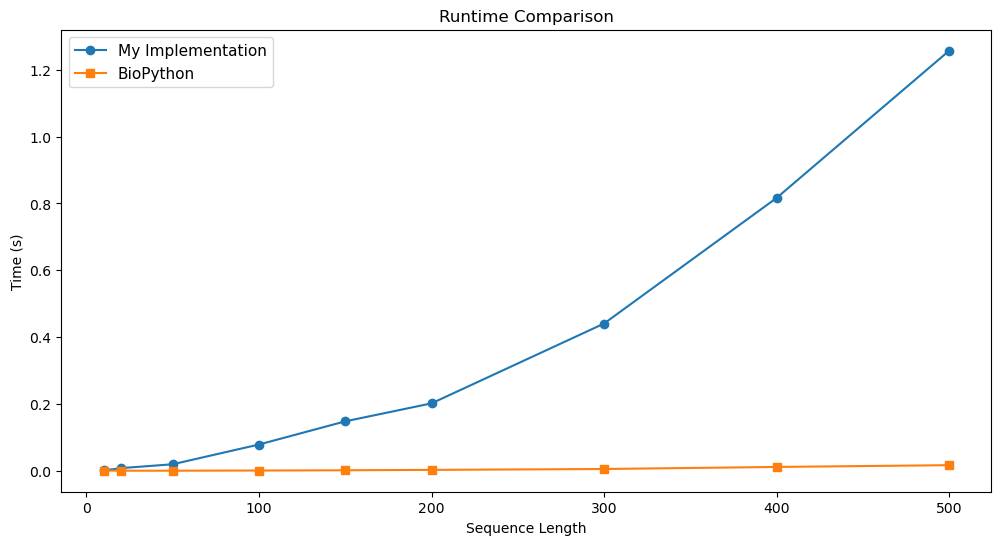

In [11]:
#creating a new figure with a specific size 
plt.figure(figsize=(12, 6))

#plotting the runtime data for my implementation
plt.plot(sequenceLengths,myTimes, 'o-', label='My Implementation')

#plotting the runtime data for biopython
plt.plot(sequenceLengths, biopythonTimes, 's-', label='BioPython')

#setting the x,y label and title 
plt.xlabel('Sequence Length')
plt.ylabel('Time (s)')
plt.title('Runtime Comparison')

#defining/labeling the 2 plots
plt.legend(fontsize=11)

#plotting it 
plt.show()

## Printing my implementation results and Validation 

In [12]:
#testing with 2 sequences
print("Verification with original test sequences:")
seq1 = "AGCTCCGTCTAG"
seq2 = "AGCCTCGTTCAG" #can put in any other sequence for testing as well

#running my implementation and getting 3 variables
my_score, aligned1, aligned2 = mySmith(seq1, seq2)
print(f"\nMy Implementation:")
print(f"Score: {my_score}")
print(f"target: {aligned1}")
print(f"query:  {aligned2}")

#running the biopython implementation and comparing the alignment score with my score, its correct hence VALIDATED
bio_score = biopythonSmith(seq1, seq2)
print(f"Biopython alignment score: {bio_score} ")

Verification with original test sequences:

My Implementation:
Score: 18
target: AGC-TCCGTCT-AG
query:  AGCCTC-GT-TCAG
Biopython alignment score: 18.0 


## While both methods implement an algorithm with the same theoretical O(N-squared) time complexity, the C-based, compiled implementation used by Biopython is much faster than the interpreted Python version for this computationally intensive task.

## Thank you!